Thermochemical convection
===========================

Rationale
---------

Our previous tutorial introduced multi-material simulations in G-ADOPT by
investigating compositional effects on buoyancy. We extend that tutorial to include
thermal effects, thereby simulating thermochemical convection, which is, for example,
essential to modelling Earth's mantle evolution.

This example
------------

Here, we consider the entrainment of a thin, compositionally dense layer by thermal
convection presented in [van Keken et al. (1997)]
(https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/97JB01353). Inside a 2-D
domain heated from below, a denser material sits at the bottom boundary beneath a
lighter material. Whilst the compositional stratification is stable, heat transfer
from the boundary generates positive buoyancy in the denser material, allowing thin
tendrils to be entrained in the convective circulation. To resolve these tendrils
using the level-set approach, significant mesh refinement is needed, making the
simulation computationally expensive. This tutorial will be updated once the
development of adaptive mesh refinement in Firedrake is complete. We describe below
the current implementation of this problem in G-ADOPT.

As with all examples, the first step is to import the `gadopt` module, which
provides access to Firedrake and associated functionality.

In [1]:
from gadopt import *

For this problem, it is useful to define a mesh with non-uniform refinement. To this
end, we use the GMSH library to generate a mesh file in a format compatible with
Firedrake. We specifically increase vertical resolution at the top and bottom
boundaries of the domain.

In [2]:
import gmsh

lx, ly = 2, 1  # Domain dimensions in x and y directions
mesh_hor_res = lx / 100  # Uniform horizontal mesh resolution
mesh_file = "mesh.msh"  # Output mesh file

gmsh.initialize()
gmsh.model.add("mesh")

point_1 = gmsh.model.geo.addPoint(0, 0, 0, mesh_hor_res)
point_2 = gmsh.model.geo.addPoint(lx, 0, 0, mesh_hor_res)

line_1 = gmsh.model.geo.addLine(point_1, point_2)

gmsh.model.geo.extrude(
    [(1, line_1)], 0, ly / 5, 0, numElements=[40], recombine=True
)  # Vertical resolution: 5e-3

gmsh.model.geo.extrude(
    [(1, line_1 + 1)], 0, ly - ly / 5 - ly / 20, 0, numElements=[15], recombine=True
)  # Vertical resolution: 5e-2

gmsh.model.geo.extrude(
    [(1, line_1 + 5)], 0, ly / 20, 0, numElements=[10], recombine=True
)  # Vertical resolution: 5e-3

gmsh.model.geo.synchronize()

gmsh.model.addPhysicalGroup(1, [line_1 + 2, line_1 + 6, line_1 + 10], tag=1)
gmsh.model.addPhysicalGroup(1, [line_1 + 3, line_1 + 7, line_1 + 11], tag=2)
gmsh.model.addPhysicalGroup(1, [line_1], tag=3)
gmsh.model.addPhysicalGroup(1, [line_1 + 9], tag=4)

gmsh.model.addPhysicalGroup(2, [line_1 + 4, line_1 + 8, line_1 + 12], tag=1)

gmsh.model.mesh.generate(2)

gmsh.write(mesh_file)
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Extruded)
Info    : [ 30%] Meshing curve 3 (Extruded)
Info    : [ 40%] Meshing curve 4 (Extruded)
Info    : [ 50%] Meshing curve 6 (Extruded)
Info    : [ 60%] Meshing curve 7 (Extruded)
Info    : [ 70%] Meshing curve 8 (Extruded)
Info    : [ 80%] Meshing curve 10 (Extruded)
Info    : [ 90%] Meshing curve 11 (Extruded)
Info    : [100%] Meshing curve 12 (Extruded)
Info    : Done meshing 1D (Wall 0.000305291s, CPU 0.000242s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 5 (Extruded)
Info    : [ 40%] Meshing surface 9 (Extruded)
Info    : [ 70%] Meshing surface 13 (Extruded)
Info    : Done meshing 2D (Wall 0.0311107s, CPU 0.031029s)
Info    : 6666 nodes 7038 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'


We next set up the mesh and function spaces and specify functions to hold our
solutions, as in our previous tutorials.

In [3]:
mesh = Mesh(mesh_file)  # Load the GMSH mesh using Firedrake
mesh.cartesian = True

left_id, right_id, bottom_id, top_id = 1, 2, 3, 4  # Boundary IDs

V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Z = MixedFunctionSpace([V, W])  # Stokes function space (mixed)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
K = FunctionSpace(mesh, "DQ", 2)  # Level-set function space (scalar, discontinuous)
R = FunctionSpace(mesh, "R", 0)  # Real space for time step

z = Function(Z)  # A field over the mixed function space Z
u, p = split(z)  # Symbolic UFL expressions for velocity and pressure
z.subfunctions[0].rename("Velocity")  # Associated Firedrake velocity function
z.subfunctions[1].rename("Pressure")  # Associated Firedrake pressure function
T = Function(Q, name="Temperature")  # Firedrake function for temperature
psi = Function(K, name="Level set")  # Firedrake function for level set

We now provide initial conditions for the level-set field. To this end, we use the
`shapely` library to represent the initial location of the material interface and
derive the signed-distance function. Finally, we apply the transformation to obtain a
smooth step function profile.

In [4]:
import numpy as np  # noqa: E402
import shapely as sl  # noqa: E402


def straight_line(x, slope, intercept):
    """Straight line equation"""
    return slope * x + intercept


interface_slope = 0  # Slope of the interface
material_interface_y = 0.025  # Vertical shift of the interface along the y axis
# Group parameters defining the straight-line profile
isd_params = (interface_slope, material_interface_y)

# Shapely LineString representation of the material interface
interface_x = np.linspace(0, lx, 1000)  # Enough points to capture the interface shape
interface_y = straight_line(interface_x, *isd_params)
line_string = sl.LineString([*np.column_stack((interface_x, interface_y))])
sl.prepare(line_string)

# Extract node coordinates
node_coords_x, node_coords_y = node_coordinates(psi)
# Determine to which material nodes belong and calculate distance to interface
node_relation_to_curve = [
    (
        node_coord_y > straight_line(node_coord_x, *isd_params),
        line_string.distance(sl.Point(node_coord_x, node_coord_y)),
    )
    for node_coord_x, node_coord_y in zip(node_coords_x, node_coords_y)
]

# Define the signed-distance function and overwrite its value array
signed_dist_to_interface = Function(K)
signed_dist_to_interface.dat.data[:] = [
    dist if is_above else -dist for is_above, dist in node_relation_to_curve
]

# Define thickness of the hyperbolic tangent profile
min_mesh_edge_length = 5e-3
epsilon = Constant(min_mesh_edge_length / 4)

# Initialise level set as a smooth step function
psi.interpolate((1 + tanh(signed_dist_to_interface / 2 / epsilon)) / 2)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7e23af254e30>, FiniteElement('DQ', quadrilateral, 2), name=None), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 0)), 10)

We next define materials present in the simulation using the `Material` class. Here,
the problem is non-dimensionalised and can be described by the product of the
expressions for the Rayleigh and buoyancy numbers, RaB, which is also referred to as
compositional Rayleigh number. Therefore, we provide a value for thermal and
compositional Rayleigh numbers to define our approximation. Material fields, such as
RaB, are created using the `field_interface` function, which generates a unique field
over the numerical domain based on the level-set field(s) and values or expressions
associated with each material. At the interface between two materials, the transition
between values or expressions can be represented as sharp or diffuse, with the latter
using averaging schemes, such as arithmetic, geometric, and harmonic means.

In [5]:
dense_material = Material(RaB=4.5e5)
reference_material = Material(RaB=0)
materials = [dense_material, reference_material]

Ra = 3e5  # Thermal Rayleigh number

RaB = field_interface(
    [psi], [material.RaB for material in materials], method="arithmetic"
)  # Compositional Rayleigh number, defined based on each material value and location

approximation = BoussinesqApproximation(Ra, RaB=RaB)

As with the previous examples, we set up an instance of the `TimestepAdaptor` class
for controlling the time-step length (via a CFL criterion) whilst the simulation
advances in time. We specify the initial time, initial time step $\Delta t$, and
output frequency (in time units).

In [6]:
time_now = 0  # Initial time
delta_t = Function(R).assign(1e-6)  # Initial time step
output_frequency = 1e-4  # Frequency (based on simulation time) at which to output
t_adapt = TimestepAdaptor(
    delta_t, u, V, target_cfl=0.6, maximum_timestep=output_frequency
)  # Current level-set advection requires a CFL condition that should not exceed 0.6.

This problem setup has a constant pressure nullspace, which corresponds to the
default case handled in G-ADOPT.

In [7]:
Z_nullspace = create_stokes_nullspace(Z)

Boundary conditions are specified next: free slip on all sides, heating from below,
and cooling from above. No boundary conditions are required for level set, as the
numerical domain is closed.

In [8]:
stokes_bcs = {
    bottom_id: {"uy": 0},
    top_id: {"uy": 0},
    left_id: {"ux": 0},
    right_id: {"ux": 0},
}
temp_bcs = {bottom_id: {"T": 1}, top_id: {"T": 0}}

We move on to initialising the temperature field.

In [9]:
X = SpatialCoordinate(mesh)  # Extract UFL representation of spatial coordinates

# Calculate quantities linked to the temperature initial condition using UFL
u0 = lx ** (7 / 3) / (1 + lx**4) ** (2 / 3) * (Ra / 2 / sqrt(pi)) ** (2 / 3)
v0 = u0
Q_ic = 2 * sqrt(lx / pi / u0)
Tu = erf((1 - X[1]) / 2 * sqrt(u0 / X[0])) / 2
Tl = 1 - 1 / 2 * erf(X[1] / 2 * sqrt(u0 / (lx - X[0])))
Tr = 1 / 2 + Q_ic / 2 / sqrt(pi) * sqrt(v0 / (X[1] + 1)) * exp(
    -(X[0] ** 2) * v0 / (4 * X[1] + 4)
)
Ts = 1 / 2 - Q_ic / 2 / sqrt(pi) * sqrt(v0 / (2 - X[1])) * exp(
    -((lx - X[0]) ** 2) * v0 / (8 - 4 * X[1])
)

# Interpolate temperature initial condition and ensure boundary condition values
T.interpolate(max_value(min_value(Tu + Tl + Tr + Ts - 3 / 2, 1), 0))
DirichletBC(Q, 1, bottom_id).apply(T)
DirichletBC(Q, 0, top_id).apply(T)

We now set up our output. To do so, we create the output file as a ParaView Data file
that uses the XML-based VTK file format. We also open a file for logging, instantiate
G-ADOPT geodynamical diagnostic utility, and define some parameters specific to this
problem.

In [10]:
output_file = VTKFile("output.pvd")

plog = ParameterLog("params.log", mesh)
plog.log_str("step time dt u_rms entrainment")

gd = GeodynamicalDiagnostics(z, T, bottom_id, top_id)

material_area = material_interface_y * lx  # Area of tracked material in the domain
entrainment_height = 0.2  # Height above which entrainment diagnostic is calculated

Here, we set up the variational problem for the energy, Stokes, and level-set
systems. The Stokes and energy systems depend on the approximation defined above,
and the level-set system includes both advection and reinitialisation components.
Subcycling is available for level-set advection and is mainly useful when the
problem at hand involves multiple CFL conditions, with the CFL for level-set
advection being the most restrictive.

In [11]:
energy_solver = EnergySolver(
    T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs
)

stokes_solver = StokesSolver(
    z,
    T,
    approximation,
    bcs=stokes_bcs,
    nullspace=Z_nullspace,
    transpose_nullspace=Z_nullspace,
)

subcycles = 1  # Number of advection solves to perform within one time step
level_set_solver = LevelSetSolver(psi, u, delta_t, eSSPRKs10p3, subcycles, epsilon)
# Increase the reinitialisation time step to make up for the coarseness of the mesh
level_set_solver.reini_params["tstep"] *= 20

Finally, we initiate the time loop, which runs until the simulation end time is
attained.

In [12]:
step = 0  # A counter to keep track of looping
output_counter = 0  # A counter to keep track of outputting
time_end = 0.02  # Will be changed to 0.05 once mesh adaptivity is available
while True:
    # Write output
    if time_now >= output_counter * output_frequency:
        output_file.write(*z.subfunctions, T, psi)
        output_counter += 1

    # Update timestep
    if time_end is not None:
        t_adapt.maximum_timestep = min(output_frequency, time_end - time_now)
    t_adapt.update_timestep()
    time_now += float(delta_t)
    step += 1

    # Solve Stokes sytem
    stokes_solver.solve()

    # Temperature system
    energy_solver.solve()

    # Advect level set
    level_set_solver.solve(step)

    # Calculate proportion of material entrained above a given height
    buoy_entr = entrainment(psi, material_area, entrainment_height)

    # Log diagnostics
    plog.log_str(f"{step} {time_now} {float(delta_t)} {gd.u_rms()} {buoy_entr}")

    # Check if simulation has completed
    if time_now >= time_end:
        log("Reached end of simulation -- exiting time-step loop")
        break

Reached end of simulation -- exiting time-step loop


At the end of the simulation, once a steady-state has been achieved, we close our
logging file and checkpoint solution fields to disk. These can later be used to
restart the simulation, if required.

In [13]:
plog.close()

with CheckpointFile("Final_State.h5", "w") as final_checkpoint:
    final_checkpoint.save_mesh(mesh)
    final_checkpoint.save_function(T, name="Temperature")
    final_checkpoint.save_function(z, name="Stokes")
    final_checkpoint.save_function(psi, name="Level set")

We can visualise the final temperature and level set fields using Firedrake's
built-in plotting functionality.

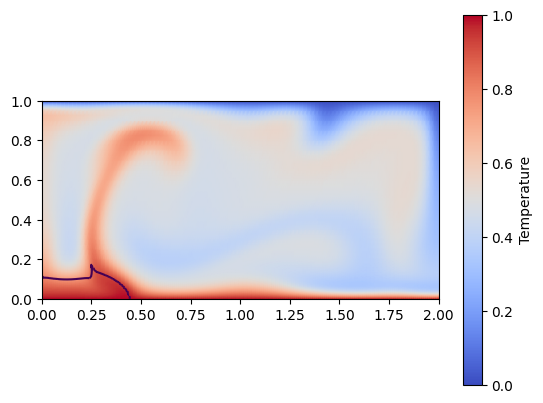

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.set_aspect("equal")
collection = tripcolor(T, axes=axes, cmap="coolwarm")
tricontour(psi, axes=axes, levels=[0.5])
fig.colorbar(collection, label="Temperature");